# Reading CSV 

In [77]:
import pandas as pd
file = "C:/Users/saimi/Downloads/un-general-debates-blueprint.csv"
df = pd.read_csv(file)
df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


# Import NLTK for stopwords

In [78]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{'up', 'shouldn', 'which', 'just', 'yourself', 'itself', 'how', "mustn't", 'being', 'wouldn', 'too', 'did', 'down', 'their', "should've", "you'd", 'hers', 'between', 'herself', 'both', 'can', 'be', 'aren', "aren't", 'me', 'against', 'about', 'what', 'are', 'd', "won't", "that'll", 'mightn', 'under', 'such', 'isn', 'him', 'our', 'again', 'any', 'a', "wouldn't", 'weren', 'below', 'only', "didn't", 'very', 'ma', 'having', 'over', 'mustn', 'is', 'out', 'own', 'from', 'with', 'does', 'whom', 'then', 'each', 'other', 'nor', 'further', "doesn't", 'before', 'themselves', 'than', 'as', "couldn't", 'why', "you've", "shan't", 'her', "isn't", 'yours', 'now', "hadn't", 'won', 'these', "you're", 'doing', 'while', "it's", 'after', 'because', 'when', 'hasn', 'if', 't', 've', 'do', 'my', 're', 'for', 'or', 'that', "you'll", 'above', 'some', 'has', "hasn't", "wasn't", 'here', "don't", 'm', 'who', 'you', 'couldn', 'will', 'am', "shouldn't", 'same', 'y', 'its', 'been', 'myself', 'all', 'yourselves', 'ours

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saimi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
import regex as re

# Creating a Pipeline

In [80]:
def tokenize(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
pipeline = [str.lower, tokenize, remove_stop]


# Apply the Pipeline

In [81]:
def prepare(text, pipeline):
    tokens = text 
    for fun in pipeline:
        tokens = fun(tokens)
    return tokens
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

# Counting the frequency of words using Counter 

In [82]:
from collections import Counter
counter = Counter()
df['tokens'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, orient='index',columns=['freq'])
freq_df = freq_df.query('freq >= 1')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(10)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


# World CLoud 

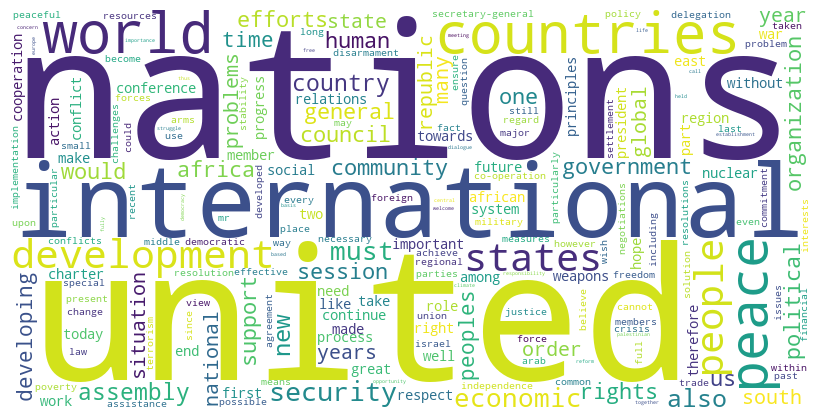

In [83]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
wc = WordCloud(background_color='white', width = 800, height=400, margin=2)
wc.fit_words(freq_df['freq'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Computing  Inverse Document Frequency(IDF)

In [84]:
import numpy as np
def compute_idf(df, column ='tokens', preprocess=None, min_df=1):
 def update(doc):
  tokens = doc if preprocess is None else preprocess(doc)
  counter.update(set(tokens))# count tokens
 counter = Counter()
 df[column].map(update)
# create data frame and compute idf
 idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
 idf_df = idf_df.query('df >= @min_df')
 idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
 idf_df.index.name = 'token'
 return idf_df
idf_df = compute_idf(df)

In [85]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head(20)

,freq,tfidf
token,,
nations,124508,12649.986284
united,120763,12285.608632
international,117223,12364.276226
world,89421,9503.708982
countries,85734,10888.485986
peace,72625,9094.508519
development,62632,8765.408844
states,59713,8373.451323
people,59338,8891.388053


# WorldCloud on tfidf 

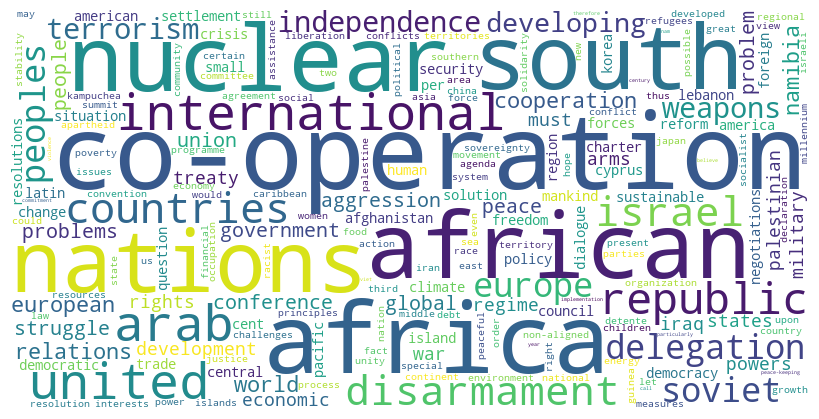

In [72]:
Wc = WordCloud(background_color='white', width = 300, height=300,margin=2)
wc.fit_words(freq_df['tfidf'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Defining Keywords to analyse

In [73]:
df['num_tokens'] = df['tokens'].map(len)
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [74]:
def count_keywords_by(df, by, keywords, column='tokens'):
    df = df.reset_index(drop=True) 
# if the supplied dataframe has gaps inthe index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix,columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    return freq_df.groupby(by=by).sum().sort_values(by)

# Heat Map on the Keywords across years 

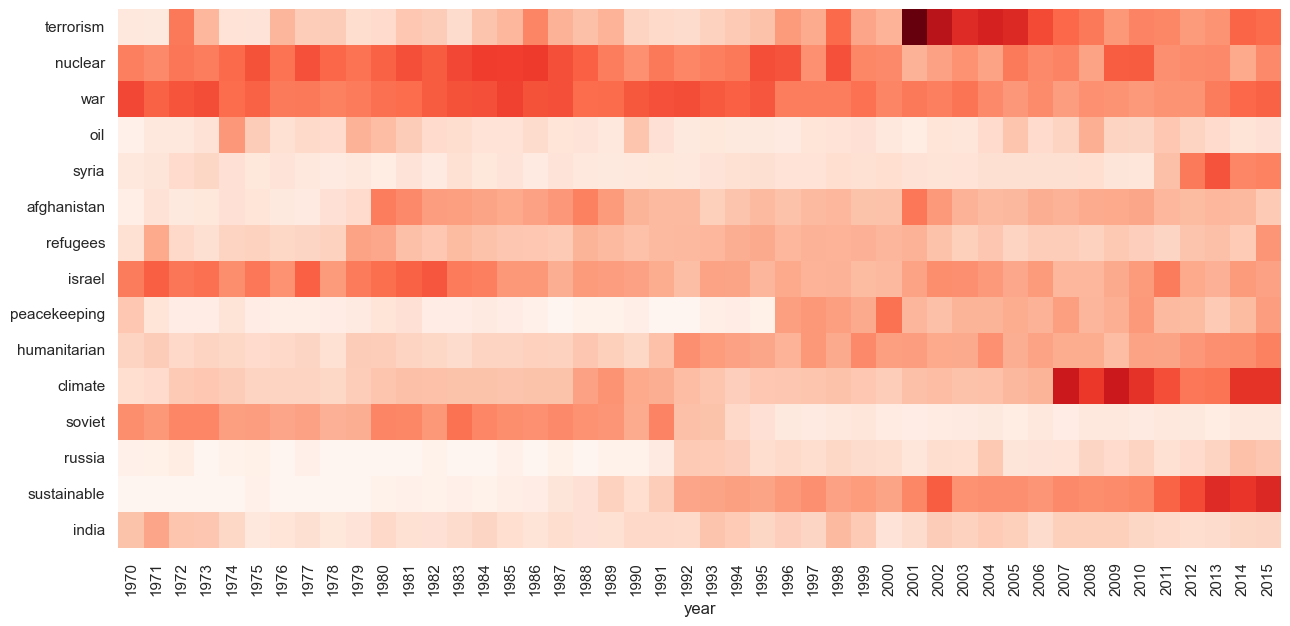

In [75]:
import seaborn as sns
keywords = ['terrorism', 'nuclear', 'war', 'oil','syria', 'afghanistan', 'refugees', 'israel', 'peacekeeping','humanitarian', 'climate', 'soviet','russia', 'sustainable','india']
freq_df = count_keywords_by(df, by='year', keywords=keywords)
# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)
plt.figure(figsize=(15, 7))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T,xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)